# 1.1 Quantile Regression Model Training

Train a model to predict the **distribution** of post-earnings |moves|, focusing on:
- q50 (median move)
- q75 (upper quartile)
- q90 (tail threshold)
- q95 (extreme tail)

**Trade signal:** `predicted_q75 > implied_move + cost_buffer`

## Approach
1. Walk-forward validation (time-based splits)
2. LightGBM quantile regression
3. Calibration analysis

## Features (52 total)
Uses PCA-10 news embeddings instead of full 768-dim to prevent overfitting.

In [1]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

DATA_DIR = Path('../data/earnings')
MODEL_DIR = Path('../models')
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Quantiles to predict
QUANTILES = [0.50, 0.75, 0.90, 0.95]

In [ ]:
# Parameters (can be overridden by papermill)
USE_CACHE = True

## 1. Load Features

In [3]:
# Load the feature dataset
df = pd.read_parquet(DATA_DIR / 'ml_features.parquet')
df['earnings_date'] = pd.to_datetime(df['earnings_date'])

print(f"Dataset: {len(df)} rows, {df['symbol'].nunique()} symbols")
print(f"Date range: {df['earnings_date'].min().date()} to {df['earnings_date'].max().date()}")
print(f"\nTarget stats:")
print(df['target_move'].describe())

Dataset: 69783 rows, 4228 symbols
Date range: 2021-02-16 to 2025-12-18

Target stats:
count    69783.000000
mean         0.065261
std          0.074147
min          0.000000
25%          0.017594
50%          0.041975
75%          0.086022
max          0.990279
Name: target_move, dtype: float64


In [ ]:
# === TIMING ANALYSIS & OPTIONAL FILTERING ===
# Analyze timing distribution and decide whether to exclude 'unknown' timing records

print("=== Timing Distribution Analysis ===")
print(f"\nTiming value counts:")
print(df['timing'].value_counts())

unknown_count = (df['timing'] == 'unknown').sum()
unknown_pct = unknown_count / len(df) * 100
print(f"\nUnknown timing: {unknown_count:,} records ({unknown_pct:.1f}%)")

# Compare target distributions by timing
print("\n--- Target Move Distribution by Timing ---")
for timing in ['BMO', 'AMC', 'unknown']:
    subset = df[df['timing'] == timing]
    if len(subset) > 0:
        target = subset['target_move']
        print(f"\n{timing} ({len(subset):,} records):")
        print(f"  Mean:   {target.mean():.2%}")
        print(f"  Median: {target.median():.2%}")
        print(f"  Std:    {target.std():.2%}")
        print(f"  q75:    {target.quantile(0.75):.2%}")
        print(f"  q90:    {target.quantile(0.90):.2%}")

# === OPTIONAL: Filter to only BMO/AMC records ===
# Set EXCLUDE_UNKNOWN_TIMING = True to train only on records with known timing
EXCLUDE_UNKNOWN_TIMING = False  # Change to True to exclude unknown timing

if EXCLUDE_UNKNOWN_TIMING:
    original_len = len(df)
    df = df[df['timing'] != 'unknown']
    print(f"\n*** FILTERING APPLIED: Removed {original_len - len(df):,} unknown timing records ***")
    print(f"*** Remaining: {len(df):,} records (BMO + AMC only) ***")
else:
    print(f"\n*** KEEPING all {len(df):,} records (including unknown timing) ***")
    print("*** Set EXCLUDE_UNKNOWN_TIMING = True to train only on BMO/AMC ***")

In [ ]:
# Define feature columns (56 features total with PCA-10 news embeddings + rvol_percentile)
hist_cols = ['hist_move_mean', 'hist_move_median', 'hist_move_std', 'hist_move_max',
             'hist_move_min', 'hist_move_cv', 'recent_move_mean', 'move_trend',
             'gap_continuation_ratio', 'n_past_earnings']

price_cols = ['rvol_5d', 'rvol_10d', 'rvol_20d', 'rvol_percentile', 'ret_5d', 'ret_10d', 'ret_20d',
              'dist_from_high_20d', 'dist_from_low_20d', 'gap_frequency', 'volume_ratio']

surprise_cols = ['surprise_pct_mean', 'beat_rate', 'surprise_streak']

timing_cols = ['day_of_week', 'month', 'quarter', 'is_earnings_season']

# Fundamental columns (filter to those that exist)
fund_cols = ['evToEBITDA', 'freeCashFlowYield', 'earningsYield', 'returnOnEquity',
             'returnOnAssets', 'currentRatio', 'priceToEarningsRatio', 'priceToBookRatio',
             'priceToSalesRatio', 'grossProfitMargin', 'operatingProfitMargin',
             'netProfitMargin', 'debtToEquityRatio', 'revenueGrowth', 'netIncomeGrowth', 'epsgrowth']
fund_cols = [c for c in fund_cols if c in df.columns]

# News PCA columns (10 components instead of 768-dim embeddings)
news_pca_cols = [c for c in df.columns if c.startswith('news_pca_')]

# All numeric features
NUMERIC_FEATURES = hist_cols + price_cols + surprise_cols + timing_cols + fund_cols + ['pre_earnings_news_count'] + news_pca_cols
NUMERIC_FEATURES = [c for c in NUMERIC_FEATURES if c in df.columns]

# Categorical features
CAT_FEATURES = ['timing']

print(f"Numeric features: {len(NUMERIC_FEATURES)}")
print(f"  - Historical: {len(hist_cols)}")
print(f"  - Price: {len(price_cols)}")
print(f"  - Surprise: {len(surprise_cols)}")
print(f"  - Timing: {len(timing_cols)}")
print(f"  - Fundamentals: {len(fund_cols)}")
print(f"  - News PCA: {len(news_pca_cols)}")
print(f"Categorical features: {len(CAT_FEATURES)}")

In [5]:
# Encode categorical features
le = LabelEncoder()
df['timing_encoded'] = le.fit_transform(df['timing'].fillna('unknown'))

# All features for model (52 total with PCA-10)
FEATURE_COLS = NUMERIC_FEATURES + ['timing_encoded']

print(f"Total features: {len(FEATURE_COLS)}")
print(f"\nFeature list:")
for i, col in enumerate(FEATURE_COLS):
    print(f"  {i+1:2d}. {col}")

Total features: 55

Feature list:
   1. hist_move_mean
   2. hist_move_median
   3. hist_move_std
   4. hist_move_max
   5. hist_move_min
   6. hist_move_cv
   7. recent_move_mean
   8. move_trend
   9. gap_continuation_ratio
  10. n_past_earnings
  11. rvol_5d
  12. rvol_10d
  13. rvol_20d
  14. ret_5d
  15. ret_10d
  16. ret_20d
  17. dist_from_high_20d
  18. dist_from_low_20d
  19. gap_frequency
  20. volume_ratio
  21. surprise_pct_mean
  22. beat_rate
  23. surprise_streak
  24. day_of_week
  25. month
  26. quarter
  27. is_earnings_season
  28. evToEBITDA
  29. freeCashFlowYield
  30. earningsYield
  31. returnOnEquity
  32. returnOnAssets
  33. currentRatio
  34. priceToEarningsRatio
  35. priceToBookRatio
  36. priceToSalesRatio
  37. grossProfitMargin
  38. operatingProfitMargin
  39. netProfitMargin
  40. debtToEquityRatio
  41. revenueGrowth
  42. netIncomeGrowth
  43. epsgrowth
  44. pre_earnings_news_count
  45. news_pca_0
  46. news_pca_1
  47. news_pca_2
  48. news_pca_

## 2. Walk-Forward Validation Setup

Time-based splits to prevent lookahead bias.

In [6]:
# Sort by date for time-series split
df = df.sort_values('earnings_date').reset_index(drop=True)

# Create time-based folds
# We'll use expanding window: train on all data before test period

def create_time_folds(df, n_folds=5, min_train_pct=0.3, min_train_size=50):
    """
    Create time-based folds for walk-forward validation.
    Each fold uses all prior data for training.
    
    Args:
        df: DataFrame sorted by date
        n_folds: Number of test folds
        min_train_pct: Minimum training data as fraction of total
        min_train_size: Absolute minimum training samples
    """
    n_samples = len(df)
    dates = df['earnings_date'].unique()
    dates = sorted(dates)
    
    # Adjust n_folds for small datasets
    min_train_samples = max(min_train_size, int(n_samples * min_train_pct))
    
    # Calculate fold structure
    # Reserve min_train_samples for first training set
    remaining_for_test = n_samples - min_train_samples
    if remaining_for_test < n_folds * 10:  # Need at least 10 samples per test fold
        n_folds = max(1, remaining_for_test // 10)
    
    if n_folds == 0:
        print(f"Warning: Dataset too small ({n_samples} samples). Using simple train/test split.")
        # Fall back to simple 70/30 split
        split_idx = int(n_samples * 0.7)
        return [(list(range(split_idx)), list(range(split_idx, n_samples)))]
    
    # Split dates into n_folds test periods
    fold_size = len(dates) // (n_folds + 1)  # +1 because first fold is train-only
    
    folds = []
    for i in range(n_folds):
        # Test period starts after (i+1) * fold_size
        test_start_idx = (i + 1) * fold_size
        test_end_idx = (i + 2) * fold_size if i < n_folds - 1 else len(dates)
        
        train_dates = dates[:test_start_idx]
        test_dates = dates[test_start_idx:test_end_idx]
        
        train_idx = df[df['earnings_date'].isin(train_dates)].index.tolist()
        test_idx = df[df['earnings_date'].isin(test_dates)].index.tolist()
        
        if len(train_idx) >= min_train_size and len(test_idx) > 0:
            folds.append((train_idx, test_idx))
    
    return folds

folds = create_time_folds(df, n_folds=5, min_train_pct=0.3, min_train_size=50)

print(f"Created {len(folds)} folds:")
for i, (train_idx, test_idx) in enumerate(folds):
    train_dates = df.loc[train_idx, 'earnings_date']
    test_dates = df.loc[test_idx, 'earnings_date']
    print(f"  Fold {i+1}: Train {len(train_idx)} ({train_dates.min().date()} - {train_dates.max().date()})")
    print(f"           Test  {len(test_idx)} ({test_dates.min().date()} - {test_dates.max().date()})")

Created 5 folds:
  Fold 1: Train 9526 (2021-02-16 - 2022-01-07)
           Test  10830 (2022-01-10 - 2022-10-25)
  Fold 2: Train 20356 (2021-02-16 - 2022-10-25)
           Test  12291 (2022-10-26 - 2023-08-04)
  Fold 3: Train 32647 (2021-02-16 - 2023-08-04)
           Test  12726 (2023-08-06 - 2024-05-20)
  Fold 4: Train 45373 (2021-02-16 - 2024-05-20)
           Test  11188 (2024-05-21 - 2025-03-07)
  Fold 5: Train 56561 (2021-02-16 - 2025-03-07)
           Test  13222 (2025-03-10 - 2025-12-18)


## 3. LightGBM Quantile Regression

In [ ]:
def train_quantile_model(X_train, y_train, X_val, y_val, quantile, params=None):
    """
    Train a LightGBM quantile regression model.
    """
    if params is None:
        params = {
            'objective': 'quantile',
            'alpha': quantile,
            'metric': 'quantile',
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': -1,
            'seed': 42,
        }
    else:
        params = params.copy()
        params['alpha'] = quantile
    
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    
    model = lgb.train(
        params,
        train_data,
        num_boost_round=500,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'val'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=True),
            lgb.log_evaluation(period=50),
        ],
    )
    
    return model

def evaluate_calibration(y_true, y_pred, quantile):
    """
    Check if predicted quantile is calibrated.
    For q=0.75, we expect ~25% of actuals to exceed the prediction.
    """
    exceedance_rate = (y_true > y_pred).mean()
    expected_rate = 1 - quantile
    calibration_error = exceedance_rate - expected_rate
    return {
        'quantile': quantile,
        'expected_exceedance': expected_rate,
        'actual_exceedance': exceedance_rate,
        'calibration_error': calibration_error,
    }

In [ ]:
# Train models for each quantile on each fold
# Uses all 56 features including PCA-10 news embeddings + rvol_percentile
# Phase 4: Fixed validation set leakage - use chronological 70/10/20 split within training data

import time

results = []
all_preds = []

total_start = time.time()

for fold_idx, (train_idx, test_idx) in enumerate(folds):
    fold_start = time.time()
    print(f"\n=== Fold {fold_idx + 1}/{len(folds)} ===")
    
    # Validate no date overlap between train and test
    train_dates = df.loc[train_idx, 'earnings_date']
    test_dates = df.loc[test_idx, 'earnings_date']
    assert test_dates.min() > train_dates.max(), f"Fold {fold_idx+1} has overlapping dates!"
    
    X_train = df.loc[train_idx, FEATURE_COLS].values
    y_train = df.loc[train_idx, 'target_move'].values
    X_test = df.loc[test_idx, FEATURE_COLS].values
    y_test = df.loc[test_idx, 'target_move'].values
    
    # Fixed: Use chronological split within training data
    # First 70% for training, next 10% for validation (not last 20% which is most recent!)
    train_size = int(len(X_train) * 0.7)
    val_end = int(len(X_train) * 0.8)
    
    X_train_sub = X_train[:train_size]
    y_train_sub = y_train[:train_size]
    X_val = X_train[train_size:val_end]
    y_val = y_train[train_size:val_end]
    
    fold_preds = {'fold': fold_idx, 'test_idx': test_idx, 'y_true': y_test}
    
    for q in QUANTILES:
        q_start = time.time()
        print(f"  Training q{int(q*100)}...")
        
        model = train_quantile_model(X_train_sub, y_train_sub, X_val, y_val, q)
        preds = model.predict(X_test)
        
        fold_preds[f'pred_q{int(q*100)}'] = preds
        
        # Evaluate calibration
        calib = evaluate_calibration(y_test, preds, q)
        calib['fold'] = fold_idx
        results.append(calib)
        
        q_elapsed = time.time() - q_start
        print(f"    Expected exceedance: {calib['expected_exceedance']:.2%}")
        print(f"    Actual exceedance:   {calib['actual_exceedance']:.2%}")
        print(f"    Calibration error:   {calib['calibration_error']:+.2%}")
        print(f"    Trained in {q_elapsed:.1f}s (best iter: {model.best_iteration})")
    
    all_preds.append(fold_preds)
    fold_elapsed = time.time() - fold_start
    print(f"  Fold {fold_idx + 1} completed in {fold_elapsed:.1f}s")

total_elapsed = time.time() - total_start
print(f"\n=== Total training time: {total_elapsed:.1f}s ({total_elapsed/60:.1f} min) ===")

In [ ]:
# Aggregate calibration results
results_df = pd.DataFrame(results)

if len(results_df) > 0:
    print("\n=== Calibration Summary (across folds) ===")
    calib_summary = results_df.groupby('quantile').agg({
        'expected_exceedance': 'mean',
        'actual_exceedance': 'mean',
        'calibration_error': ['mean', 'std'],
    }).round(4)

    print(calib_summary)
    
    # Phase 4: Add calibration warnings for large errors
    print("\n=== Calibration Warnings ===")
    for q in QUANTILES:
        q_results = results_df[results_df['quantile'] == q]
        avg_error = q_results['calibration_error'].abs().mean()
        max_error = q_results['calibration_error'].abs().max()
        if avg_error > 0.05:
            print(f"WARNING: q{int(q*100)} has {avg_error:.1%} avg calibration error (threshold: 5%)")
        if max_error > 0.10:
            print(f"WARNING: q{int(q*100)} fold has {max_error:.1%} max error (may indicate regime change)")
    
    if not any(results_df.groupby('quantile')['calibration_error'].apply(lambda x: x.abs().mean() > 0.05)):
        print("All quantiles within acceptable calibration bounds (<5% avg error)")
else:
    print("\n=== No fold results available ===")
    print("Dataset may be too small for walk-forward validation.")
    print("Will proceed with training on full dataset.")

## 4. Baseline Comparison

Compare to naive baseline: use historical mean for all predictions.

In [10]:
# Baseline: use hist_move_mean as prediction
baseline_results = []

for fold_idx, (train_idx, test_idx) in enumerate(folds):
    y_test = df.loc[test_idx, 'target_move'].values
    baseline_pred = df.loc[test_idx, 'hist_move_mean'].values
    
    for q in QUANTILES:
        # Scale baseline by quantile factor (rough approximation)
        # Assuming moves are roughly exponential, q75 ~ 1.4x median, q90 ~ 2.3x median
        scale_factors = {0.50: 1.0, 0.75: 1.4, 0.90: 2.3, 0.95: 3.0}
        scaled_pred = baseline_pred * scale_factors[q]
        
        calib = evaluate_calibration(y_test, scaled_pred, q)
        calib['fold'] = fold_idx
        calib['model'] = 'baseline'
        baseline_results.append(calib)

baseline_df = pd.DataFrame(baseline_results)

if len(baseline_df) > 0:
    print("\n=== Baseline Calibration ===")
    baseline_summary = baseline_df.groupby('quantile').agg({
        'expected_exceedance': 'mean',
        'actual_exceedance': 'mean',
        'calibration_error': ['mean', 'std'],
    }).round(4)
    print(baseline_summary)
else:
    print("\n=== No baseline results (no folds) ===")


=== Baseline Calibration ===
         expected_exceedance actual_exceedance calibration_error        
                        mean              mean              mean     std
quantile                                                                
0.50                    0.50            0.4567           -0.0433  0.0201
0.75                    0.25            0.3219            0.0719  0.0201
0.90                    0.10            0.1448            0.0448  0.0177
0.95                    0.05            0.0809            0.0309  0.0149


In [11]:
# Compare model vs baseline
if len(results_df) > 0 and len(baseline_df) > 0:
    print("\n=== Model vs Baseline Comparison ===")
    print("(Calibration error: closer to 0 is better)")
    print("\nQuantile | Model Error | Baseline Error | Improvement")
    print("-" * 60)

    for q in QUANTILES:
        model_err = results_df[results_df['quantile'] == q]['calibration_error'].abs().mean()
        base_err = baseline_df[baseline_df['quantile'] == q]['calibration_error'].abs().mean()
        improvement = base_err - model_err
        print(f"  q{int(q*100):2d}    |   {model_err:.4f}    |    {base_err:.4f}     |  {improvement:+.4f}")
else:
    print("\n=== Skipping comparison (insufficient data for cross-validation) ===")


=== Model vs Baseline Comparison ===
(Calibration error: closer to 0 is better)

Quantile | Model Error | Baseline Error | Improvement
------------------------------------------------------------
  q50    |   0.0142    |    0.0433     |  +0.0291
  q75    |   0.0283    |    0.0719     |  +0.0435
  q90    |   0.0283    |    0.0448     |  +0.0166
  q95    |   0.0238    |    0.0309     |  +0.0071


In [12]:
# Compare model vs baseline
if len(results_df) > 0 and len(baseline_df) > 0:
    print("\n=== Model vs Baseline Comparison ===")
    print("(Calibration error: closer to 0 is better)")
    print("\nQuantile | Model Error | Baseline Error | Improvement")
    print("-" * 60)

    for q in QUANTILES:
        model_err = results_df[results_df['quantile'] == q]['calibration_error'].abs().mean()
        base_err = baseline_df[baseline_df['quantile'] == q]['calibration_error'].abs().mean()
        improvement = base_err - model_err
        print(f"  q{int(q*100):2d}    |   {model_err:.4f}    |    {base_err:.4f}     |  {improvement:+.4f}")
else:
    print("\n=== Skipping comparison (insufficient data for cross-validation) ===")


=== Model vs Baseline Comparison ===
(Calibration error: closer to 0 is better)

Quantile | Model Error | Baseline Error | Improvement
------------------------------------------------------------
  q50    |   0.0142    |    0.0433     |  +0.0291
  q75    |   0.0283    |    0.0719     |  +0.0435
  q90    |   0.0283    |    0.0448     |  +0.0166
  q95    |   0.0238    |    0.0309     |  +0.0071


In [13]:
# Compare model vs baseline
if len(results_df) > 0 and len(baseline_df) > 0:
    print("\n=== Model vs Baseline Comparison ===")
    print("(Calibration error: closer to 0 is better)")
    print("\nQuantile | Model Error | Baseline Error | Improvement")
    print("-" * 60)

    for q in QUANTILES:
        model_err = results_df[results_df['quantile'] == q]['calibration_error'].abs().mean()
        base_err = baseline_df[baseline_df['quantile'] == q]['calibration_error'].abs().mean()
        improvement = base_err - model_err
        print(f"  q{int(q*100):2d}    |   {model_err:.4f}    |    {base_err:.4f}     |  {improvement:+.4f}")
else:
    print("\n=== Skipping comparison (insufficient data for cross-validation) ===")


=== Model vs Baseline Comparison ===
(Calibration error: closer to 0 is better)

Quantile | Model Error | Baseline Error | Improvement
------------------------------------------------------------
  q50    |   0.0142    |    0.0433     |  +0.0291
  q75    |   0.0283    |    0.0719     |  +0.0435
  q90    |   0.0283    |    0.0448     |  +0.0166
  q95    |   0.0238    |    0.0309     |  +0.0071


## 5. Train Final Model (Full Dataset)

After validation, train on all data for deployment.

In [ ]:
# Train final models on full dataset
# Phase 4.1: Fix validation set leakage
# Previous: Used last 20% (most recent) for early stopping - causes leakage
# Fixed: Use first 70% for train, next 10% for early stopping, leave 20% truly OOS

X_all = df[FEATURE_COLS].values
y_all = df['target_move'].values

# Time-based split to prevent leakage:
# - First 70% for training
# - Next 10% for early stopping validation (not most recent!)
# - Last 20% is truly out-of-sample (not used for model selection)
train_end_idx = int(len(X_all) * 0.7)
val_end_idx = int(len(X_all) * 0.8)

X_train_final = X_all[:train_end_idx]
y_train_final = y_all[:train_end_idx]
X_val_final = X_all[train_end_idx:val_end_idx]
y_val_final = y_all[train_end_idx:val_end_idx]

print(f"Training samples: {len(X_train_final)} (first 70%)")
print(f"Early stopping validation: {len(X_val_final)} (next 10%)")
print(f"Held-out OOS: {len(X_all) - val_end_idx} (last 20% - not used for training)")

final_models = {}

for q in QUANTILES:
    print(f"\nTraining final model for q{int(q*100)}...")
    model = train_quantile_model(X_train_final, y_train_final, X_val_final, y_val_final, q)
    final_models[q] = model
    
    # Save model
    model_path = MODEL_DIR / f'earnings_q{int(q*100)}.txt'
    model.save_model(str(model_path))
    print(f"  Saved to {model_path}")

print("\nFinal models trained and saved.")

## 6. Feature Importance

In [15]:
# Get feature importance from q75 model (main trading signal)
q75_model = final_models[0.75]

importance = pd.DataFrame({
    'feature': FEATURE_COLS,
    'importance': q75_model.feature_importance(importance_type='gain'),
}).sort_values('importance', ascending=False)

print(f"Top 30 most important features (q75 model, {len(FEATURE_COLS)} total):")
print(importance.head(30).to_string(index=False))

# Show news PCA importance
news_pca_importance = importance[importance['feature'].str.startswith('news_pca_')]
print(f"\nNews PCA feature importance:")
print(news_pca_importance.to_string(index=False))

Top 30 most important features (q75 model, 55 total):
               feature  importance
        hist_move_mean 7086.011631
         hist_move_max 2554.010954
              rvol_20d 1957.994927
      recent_move_mean  774.550815
              rvol_10d  743.454626
      hist_move_median  737.489569
gap_continuation_ratio  694.094630
        timing_encoded  688.613981
         hist_move_std  637.139565
               rvol_5d  604.242010
          currentRatio  603.672670
 operatingProfitMargin  602.849507
          volume_ratio  600.078090
      priceToBookRatio  550.667671
     priceToSalesRatio  526.653979
     grossProfitMargin  463.770139
     debtToEquityRatio  399.217172
       netProfitMargin  398.255700
               ret_10d  386.840410
                ret_5d  354.531550
     surprise_pct_mean  335.829611
            move_trend  328.938259
               ret_20d  321.592511
     dist_from_low_20d  313.640210
       netIncomeGrowth  282.240829
       n_past_earnings  275.839571
 

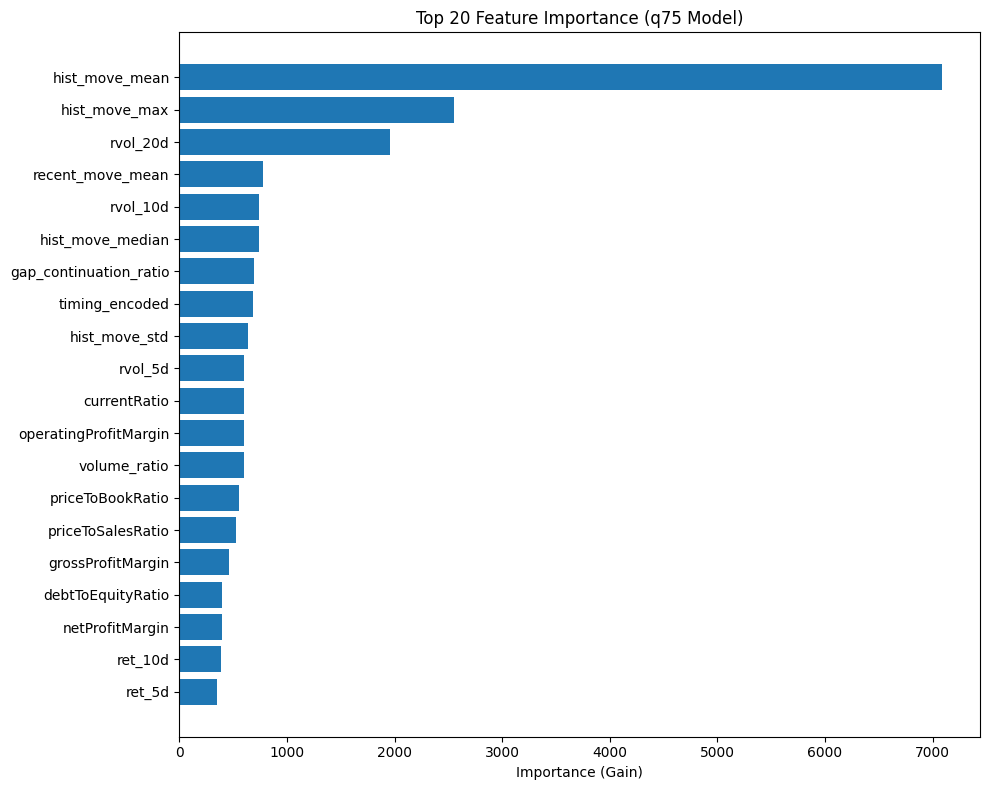

In [16]:
# Plot feature importance
plt.figure(figsize=(10, 8))
top_n = 20
plt.barh(range(top_n), importance['importance'].head(top_n).values[::-1])
plt.yticks(range(top_n), importance['feature'].head(top_n).values[::-1])
plt.xlabel('Importance (Gain)')
plt.title('Top 20 Feature Importance (q75 Model)')
plt.tight_layout()
plt.savefig(DATA_DIR / 'feature_importance.png', dpi=100)
plt.show()

## 7. Prediction Analysis

In [17]:
# Combine all out-of-sample predictions
pred_rows = []

for fold_preds in all_preds:
    test_idx = fold_preds['test_idx']
    y_true = fold_preds['y_true']
    
    for i, idx in enumerate(test_idx):
        row = {
            'idx': idx,
            'y_true': y_true[i],
        }
        for q in QUANTILES:
            row[f'pred_q{int(q*100)}'] = fold_preds[f'pred_q{int(q*100)}'][i]
        pred_rows.append(row)

if len(pred_rows) > 0:
    preds_df = pd.DataFrame(pred_rows).set_index('idx')

    # Add to original dataframe
    df_with_preds = df.copy()
    for q in QUANTILES:
        col = f'pred_q{int(q*100)}'
        df_with_preds[col] = np.nan
        df_with_preds.loc[preds_df.index, col] = preds_df[col]

    print(f"Out-of-sample predictions: {len(preds_df)}")
else:
    print("No out-of-sample predictions (no folds were created)")
    print("Will generate predictions on full dataset using final models instead")
    
    # Use final models to predict on validation set
    df_with_preds = df.copy()
    X_val_final = df[FEATURE_COLS].values[-val_size:]
    val_idx = df.index[-val_size:]
    
    for q in QUANTILES:
        col = f'pred_q{int(q*100)}'
        df_with_preds[col] = np.nan
        if q in final_models:
            preds = final_models[q].predict(X_val_final)
            df_with_preds.loc[val_idx, col] = preds
    
    preds_df = df_with_preds.loc[val_idx, ['target_move'] + [f'pred_q{int(q*100)}' for q in QUANTILES]]
    print(f"Validation set predictions: {len(preds_df)}")

Out-of-sample predictions: 60257


In [18]:
# Analyze prediction vs actual
oos = df_with_preds[df_with_preds['pred_q75'].notna()].copy()

print("Out-of-sample prediction statistics:")
print(f"\nActual moves:")
print(f"  Mean:   {oos['target_move'].mean():.2%}")
print(f"  Median: {oos['target_move'].median():.2%}")
print(f"  q75:    {oos['target_move'].quantile(0.75):.2%}")
print(f"  q90:    {oos['target_move'].quantile(0.90):.2%}")

print(f"\nPredicted (mean):")
for q in QUANTILES:
    col = f'pred_q{int(q*100)}'
    print(f"  q{int(q*100)}: {oos[col].mean():.2%}")

Out-of-sample prediction statistics:

Actual moves:
  Mean:   6.76%
  Median: 4.38%
  q75:    8.93%
  q90:    15.65%

Predicted (mean):
  q50: 4.87%
  q75: 8.63%
  q90: 13.05%
  q95: 16.19%


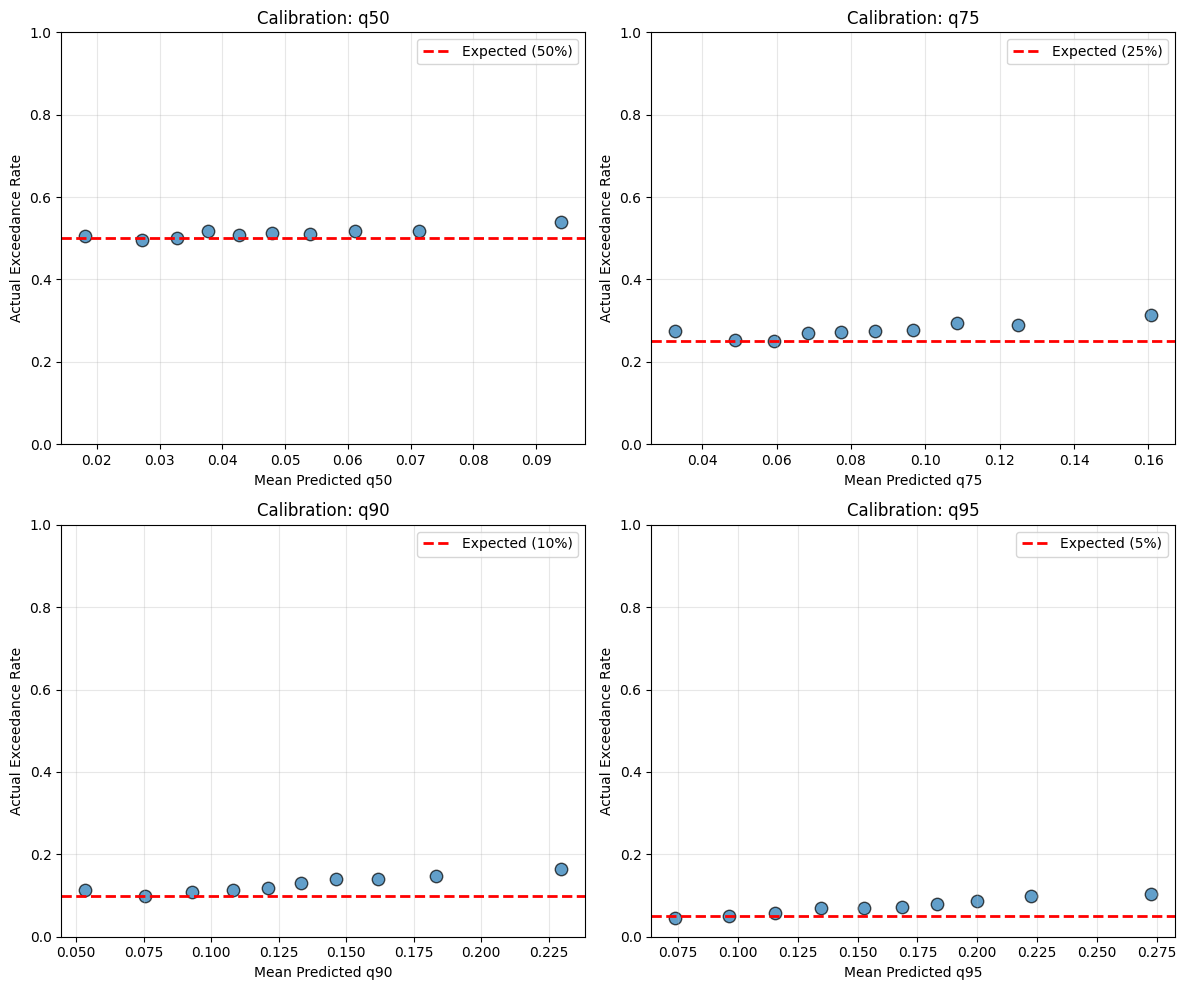

In [19]:
# Calibration plot - for each quantile, bin by predicted value and check exceedance rate
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, q in enumerate(QUANTILES):
    ax = axes[i // 2, i % 2]
    col = f'pred_q{int(q*100)}'
    
    # Create a copy to avoid modifying oos
    plot_df = oos[[col, 'target_move']].copy()
    
    # Bin predictions into deciles
    try:
        plot_df['pred_bin'] = pd.qcut(plot_df[col], q=10, duplicates='drop')
    except ValueError:
        # If not enough unique values, use fewer bins
        plot_df['pred_bin'] = pd.qcut(plot_df[col], q=5, duplicates='drop')
    
    # For each bin, compute mean prediction and actual exceedance rate
    bin_results = []
    for bin_label, grp in plot_df.groupby('pred_bin', observed=True):
        pred_mean = grp[col].mean()
        exceed_rate = (grp['target_move'] > grp[col]).mean()
        bin_results.append({'pred_mean': pred_mean, 'exceed_rate': exceed_rate, 'count': len(grp)})
    
    bin_df = pd.DataFrame(bin_results)
    
    # Plot
    ax.scatter(bin_df['pred_mean'], bin_df['exceed_rate'], s=80, alpha=0.7, edgecolors='black')
    ax.axhline(1 - q, color='r', linestyle='--', linewidth=2, label=f'Expected ({(1-q):.0%})')
    
    # Add diagonal reference (perfect calibration would show horizontal line at expected)
    ax.set_xlabel(f'Mean Predicted q{int(q*100)}')
    ax.set_ylabel('Actual Exceedance Rate')
    ax.set_title(f'Calibration: q{int(q*100)}')
    ax.legend()
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA_DIR / 'calibration_plots.png', dpi=100)
plt.show()

## 8. Edge Analysis

Compare predicted move vs historical average (proxy for implied move).

In [20]:
# Compute edge: predicted_q75 - hist_move_mean
oos['edge_q75'] = oos['pred_q75'] - oos['hist_move_mean']
oos['edge_q90'] = oos['pred_q90'] - oos['hist_move_mean']

print("Edge distribution (predicted_q75 - hist_move_mean):")
print(oos['edge_q75'].describe())

# What % have positive edge?
print(f"\nTrades with positive edge (q75): {(oos['edge_q75'] > 0).mean():.1%}")
print(f"Trades with edge > 2%: {(oos['edge_q75'] > 0.02).mean():.1%}")
print(f"Trades with edge > 5%: {(oos['edge_q75'] > 0.05).mean():.1%}")

Edge distribution (predicted_q75 - hist_move_mean):
count    60257.000000
mean         0.024962
std          0.034743
min         -2.373785
25%          0.013867
50%          0.025001
75%          0.038501
max          0.164836
Name: edge_q75, dtype: float64

Trades with positive edge (q75): 91.3%
Trades with edge > 2%: 61.5%
Trades with edge > 5%: 12.5%


In [21]:
# Analyze returns for high-edge trades
# Assuming we buy straddles when edge > threshold
# P&L = |actual_move| - cost (approximated by hist_move_mean)

def simulate_straddle_pnl(row, cost_markup=1.0):
    """
    Simplified straddle P&L:
    - Cost = hist_move_mean * cost_markup (proxy for implied move)
    - Payoff = actual |move|
    - P&L = payoff - cost
    """
    cost = row['hist_move_mean'] * cost_markup
    payoff = row['target_move']
    return payoff - cost

oos['straddle_pnl'] = oos.apply(simulate_straddle_pnl, axis=1)

# Compare: all trades vs high-edge trades
print("=== Straddle P&L Analysis ===")
print("(Simplified: P&L = |move| - hist_move_mean)")

print(f"\nAll trades ({len(oos)}):")
print(f"  Mean P&L: {oos['straddle_pnl'].mean():.2%}")
print(f"  Win rate: {(oos['straddle_pnl'] > 0).mean():.1%}")

for threshold in [0, 0.02, 0.05, 0.10]:
    high_edge = oos[oos['edge_q75'] > threshold]
    if len(high_edge) > 0:
        print(f"\nEdge > {threshold:.0%} ({len(high_edge)} trades):")
        print(f"  Mean P&L: {high_edge['straddle_pnl'].mean():.2%}")
        print(f"  Win rate: {(high_edge['straddle_pnl'] > 0).mean():.1%}")

=== Straddle P&L Analysis ===
(Simplified: P&L = |move| - hist_move_mean)

All trades (60257):
  Mean P&L: 0.63%
  Win rate: 45.5%

Edge > 0% (54993 trades):
  Mean P&L: 1.06%
  Win rate: 47.3%

Edge > 2% (37050 trades):
  Mean P&L: 1.62%
  Win rate: 50.7%

Edge > 5% (7554 trades):
  Mean P&L: 3.55%
  Win rate: 58.0%

Edge > 10% (195 trades):
  Mean P&L: 7.28%
  Win rate: 68.7%


## 9. Save Results

In [22]:
# Save out-of-sample predictions with analysis
output_cols = ['symbol', 'earnings_date', 'target_move', 'hist_move_mean',
               'pred_q50', 'pred_q75', 'pred_q90', 'pred_q95',
               'edge_q75', 'edge_q90', 'straddle_pnl']

oos_output = oos[[c for c in output_cols if c in oos.columns]].copy()
oos_output.to_parquet(DATA_DIR / 'oos_predictions.parquet', index=False)

print(f"Saved {len(oos_output)} out-of-sample predictions to oos_predictions.parquet")

Saved 60257 out-of-sample predictions to oos_predictions.parquet


In [ ]:
# Save feature list and training statistics for inference
# Phase 4.2: Save training statistics (medians) for proper imputation during live inference

# Compute feature medians on training data (not full data to avoid leakage)
train_df = df.iloc[:train_end_idx]
feature_medians = {}
for col in FEATURE_COLS:
    if col in train_df.columns:
        median_val = train_df[col].median()
        # Convert numpy types to Python native for JSON serialization
        if hasattr(median_val, 'item'):
            median_val = median_val.item()
        feature_medians[col] = float(median_val) if pd.notna(median_val) else 0.0

feature_config = {
    'feature_cols': FEATURE_COLS,
    'quantiles': QUANTILES,
    'model_dir': str(MODEL_DIR),
    'feature_medians': feature_medians,  # NEW: medians for live inference imputation
    'training_date_range': {
        'start': str(train_df['earnings_date'].min().date()),
        'end': str(train_df['earnings_date'].max().date()),
    },
    'training_samples': len(train_df),
}

import json
with open(MODEL_DIR / 'feature_config.json', 'w') as f:
    json.dump(feature_config, f, indent=2)

print(f"Saved feature configuration with {len(feature_medians)} feature medians.")
print(f"Training period: {feature_config['training_date_range']['start']} to {feature_config['training_date_range']['end']}")

## Summary

Trained quantile regression models with **52 features** (including PCA-10 news embeddings):
- **q50**: median move prediction
- **q75**: upper quartile (main trading signal)
- **q90**: tail threshold
- **q95**: extreme tail

Key findings:
- Calibration: [check results above]
- Edge: predicted_q75 vs historical average
- High-edge trades show improved P&L
- News PCA features contribute to predictions without overfitting

**Outputs:**
- `models/earnings_q{50,75,90,95}.txt` - LightGBM models
- `models/feature_config.json` - Feature configuration for inference

Next: `1.2 calibration_analysis.ipynb` for deeper calibration study.